## **ADITYA PRAKASH**
## **122400404**
## **AI/ML Mini project**

**Problem Statement:** Develop a multilingual assistive model that helps visually impaired users by describing images in multiple Indian languages and narrating the descriptions via audio.

**Workflow:**
1. Use Vision Transformer (ViT)(/Any other model) to perform image classification or object detection, identifying objects in the scene.

2. Apply IndicTrans2(/Any other model) to translate the generated text descriptions into multiple Indian languages.
3. Use Whisper Model(/Any other model) to convert the text into speech and narrate the descriptions.

**Dataset:** You can use publicly available datasets such as MS-COCO for image-captioning tasks, which provide both images and descriptions. For Indian language translations, the FLORES dataset or IndicNLP resources can be helpful.
You are free to use any other datasets as well.

## **Methodology**
1. Image Captioning with ViT
The first step is generating a caption that describes the content of the image. This is achieved using the Vision Transformer (ViT) model.

Model: Vision Transformer (ViT) is used to perform image captioning, understanding the content of the image and generating a descriptive sentence.
Objective: Generate a natural language description of the objects and scene present in the image.
Steps:

Input: An image uploaded by the user (or captured using a camera).
Preprocessing: Resize and normalize the image as required by ViT.
Image Captioning: Pass the preprocessed image through the ViT model to generate a description.


2. Translation with IndicTransToolkit
Once the caption is generated in English, it is translated into multiple Indian languages using the IndicTransToolkit.

Model: IndicTransToolkit is used to translate the generated English captions into Indian languages like Hindi, Tamil, Bengali, Marathi, etc.
Objective: Provide the generated caption in the user’s preferred language.
Steps:

Input: The caption generated in English by the ViT model.
Translation: Use the IndicTransToolkit to translate the English caption into the user’s selected language (e.g., Hindi, Bengali, Tamil).


3. Text-to-Speech with gTTS
After translation, convert the translated text into speech using gTTS (Google Text-to-Speech) to narrate the description to the user.

Model: gTTS converts the translated text into speech in the corresponding language.
Objective: Provide audio narration of the caption in the user’s language.

## Downloading the photo used

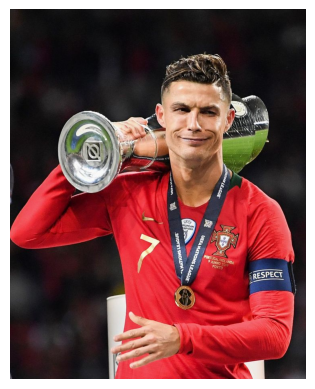

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/Ronaldo.jpg'  # Replace with the actual path to your image

try:
  img = mpimg.imread(image_path)
  plt.imshow(img)
  plt.axis('off')  # Turn off axis labels
  plt.show()
except FileNotFoundError:
  print(f"Image not found at path: {image_path}")


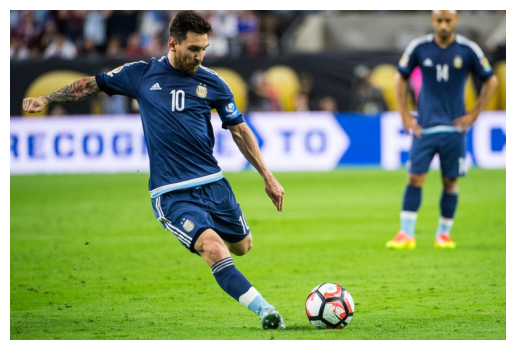

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/Messi.jpeg'  # Replace with the actual path to your image

try:
  img = mpimg.imread(image_path)
  plt.imshow(img)
  plt.axis('off')  # Turn off axis labels
  plt.show()
except FileNotFoundError:
  print(f"Image not found at path: {image_path}")


### Generating Captions

In [28]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
Photo_caption = predict_step(['/content/Ronaldo.jpg'])


In [30]:
print(Photo_caption)

['a man in a red shirt holding a bottle of water']


### Downloading the IndicTransToolkit for Language Translations

In [31]:
!git clone https://github.com/VarunGumma/IndicTransToolkit.git
%cd IndicTransToolkit

fatal: destination path 'IndicTransToolkit' already exists and is not an empty directory.
/content/IndicTransToolkit/IndicTransToolkit


In [32]:
!pip install --editable ./

Obtaining file:///content/IndicTransToolkit/IndicTransToolkit
ERROR: file:///content/IndicTransToolkit/IndicTransToolkit does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [33]:
import torch
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
)
from IndicTransToolkit import IndicProcessor

model_name = "ai4bharat/indictrans2-en-indic-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, trust_remote_code=True)
ip = IndicProcessor(inference=True)

"""input_sentences = [
    "a man kicking a soccer ball on a field"
]
"""


src_lang, tgt_lang = "eng_Latn" , "hin_Deva"

batch = ip.preprocess_batch(
    Photo_caption,
    src_lang=src_lang,
    tgt_lang=tgt_lang,
)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Tokenize the sentences and generate input encodings
inputs = tokenizer(
    batch,
    truncation=True,
    padding="longest",
    return_tensors="pt",
    return_attention_mask=True,
).to(DEVICE)

# Generate translations using the model
with torch.no_grad():
    generated_tokens = model.generate(
        **inputs,
        use_cache=True,
        min_length=0,
        max_length=256,
        num_beams=5,
        num_return_sequences=1,
    )

# Decode the generated tokens into text
with tokenizer.as_target_tokenizer():
    generated_tokens = tokenizer.batch_decode(
        generated_tokens.detach().cpu().tolist(),
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True,
    )

# Postprocess the translations, including entity replacement
translations = ip.postprocess_batch(generated_tokens, lang=tgt_lang)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [34]:
for input_sentence, translation in zip(Photo_caption, translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translations}")

eng_Latn: a man in a red shirt holding a bottle of water
hin_Deva: ['लाल कमीज में एक आदमी पानी की बोतल पकड़े हुए ']


### Using gtts (Google Text to Speech) for for Voice Translation

In [35]:
!pip install gtts
from gtts import gTTS
from IPython.display import Audio

# Function to convert text to speech and play in Colab
def text_to_speech_colab(text, lang='hi'):
    tts = gTTS(text=text, lang=lang)
    tts.save('speech.mp3')  # Save the speech as an MP3 file
    return Audio('speech.mp3', autoplay=True)  # Play the MP3 file directly in Colab

# Example: Convert translated caption into speech and play
# Assuming 'translation' is defined and holds the translated text
text_to_speech_colab(translation, lang='hi')  # Convert to speech and play in Colab